## 1. Imports and Setup

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt

# Device configuration
DEVICE = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {DEVICE}")

Using device: cpu


In [3]:
from torch.distributions import Normal

class ActorCritic(nn.Module):
    is_recurrent = False

    def __init__(
        self,
        num_actor_obs,
        num_critic_obs,
        num_actions,
        actor_hidden_dims=[512, 256, 128],
        critic_hidden_dims=[512, 256, 128],
        init_noise_std=1.0,
        noise_std_type: str = "scalar",
    ):

        super().__init__()
        activation = torch.nn.ReLU()

        mlp_input_dim_a = num_actor_obs
        mlp_input_dim_c = num_critic_obs
        # Policy
        actor_layers = []
        actor_layers.append(nn.Linear(mlp_input_dim_a, actor_hidden_dims[0]))
        actor_layers.append(activation)
        for layer_index in range(len(actor_hidden_dims)):
            if layer_index == len(actor_hidden_dims) - 1:
                actor_layers.append(nn.Linear(actor_hidden_dims[layer_index], num_actions))
            else:
                actor_layers.append(nn.Linear(actor_hidden_dims[layer_index], actor_hidden_dims[layer_index + 1]))
                actor_layers.append(activation)
        self.actor = nn.Sequential(*actor_layers)

        # Value function
        critic_layers = []
        critic_layers.append(nn.Linear(mlp_input_dim_c, critic_hidden_dims[0]))
        critic_layers.append(activation)
        for layer_index in range(len(critic_hidden_dims)):
            if layer_index == len(critic_hidden_dims) - 1:
                critic_layers.append(nn.Linear(critic_hidden_dims[layer_index], 1))
            else:
                critic_layers.append(nn.Linear(critic_hidden_dims[layer_index], critic_hidden_dims[layer_index + 1]))
                critic_layers.append(activation)
        self.critic = nn.Sequential(*critic_layers)

        print(f"Actor MLP: {self.actor}")
        print(f"Critic MLP: {self.critic}")

        # Action noise
        self.noise_std_type = noise_std_type
        if self.noise_std_type == "scalar":
            self.std = nn.Parameter(init_noise_std * torch.ones(num_actions))
        elif self.noise_std_type == "log":
            self.log_std = nn.Parameter(torch.log(init_noise_std * torch.ones(num_actions)))
        else:
            raise ValueError(f"Unknown standard deviation type: {self.noise_std_type}. Should be 'scalar' or 'log'")
        print(self.std)

        # Action distribution (populated in update_distribution)
        self.distribution = None
        # disable args validation for speedup
        Normal.set_default_validate_args(False)

    @staticmethod
    # not used at the moment
    def init_weights(sequential, scales):
        [
            torch.nn.init.orthogonal_(module.weight, gain=scales[idx])
            for idx, module in enumerate(mod for mod in sequential if isinstance(mod, nn.Linear))
        ]

    def reset(self, dones=None):
        pass

    

    @property
    def action_mean(self):
        return self.distribution.mean

    @property
    def action_std(self):
        return self.distribution.stddev

    @property
    def entropy(self):
        return self.distribution.entropy().sum(dim=-1)

    def update_distribution(self, observations):
        # compute mean
        mean = self.actor(observations)
        # compute standard deviation
        if self.noise_std_type == "scalar":
            std = self.std.expand_as(mean)
        elif self.noise_std_type == "log":
            std = torch.exp(self.log_std).expand_as(mean)
        else:
            raise ValueError(f"Unknown standard deviation type: {self.noise_std_type}. Should be 'scalar' or 'log'")
        # create distribution
        self.distribution = Normal(mean, std)

    def act(self, observations, **kwargs):
        self.update_distribution(observations)
        return self.distribution.sample()

    def get_actions_log_prob(self, actions):
        return self.distribution.log_prob(actions).sum(dim=-1)

    def act_inference(self, observations):
        actions_mean = self.actor(observations)
        return actions_mean

    def evaluate(self, critic_observations, **kwargs):
        value = self.critic(critic_observations)
        return value
    
    def forward(self, observations):
        return self.act_inference(observations)

    def load_state_dict(self, state_dict, strict=True):
        """Load the parameters of the actor-critic model.

        Args:
            state_dict (dict): State dictionary of the model.
            strict (bool): Whether to strictly enforce that the keys in state_dict match the keys returned by this
                           module's state_dict() function.

        Returns:
            bool: Whether this training resumes a previous training. This flag is used by the `load()` function of
                  `OnPolicyRunner` to determine how to load further parameters (relevant for, e.g., distillation).
        """

        super().load_state_dict(state_dict, strict=strict)
        return True

model = ActorCritic(
    num_actor_obs=16*3,
    num_critic_obs=16*3,
    num_actions=1,
    actor_hidden_dims=[512, 256, 128],
    critic_hidden_dims=[512, 256, 128],
    init_noise_std=0,
    noise_std_type="scalar",
)
checkpoint = torch.load("2025-03-27_11-34-55_2150.pt", map_location=torch.device("cpu"), weights_only=True)  # Adjust path
model.load_state_dict(checkpoint["model_state_dict"])
# model.eval()
# model.std  = nn.Parameter(0 * torch.ones(1))

Actor MLP: Sequential(
  (0): Linear(in_features=48, out_features=512, bias=True)
  (1): ReLU()
  (2): Linear(in_features=512, out_features=256, bias=True)
  (3): ReLU()
  (4): Linear(in_features=256, out_features=128, bias=True)
  (5): ReLU()
  (6): Linear(in_features=128, out_features=1, bias=True)
)
Critic MLP: Sequential(
  (0): Linear(in_features=48, out_features=512, bias=True)
  (1): ReLU()
  (2): Linear(in_features=512, out_features=256, bias=True)
  (3): ReLU()
  (4): Linear(in_features=256, out_features=128, bias=True)
  (5): ReLU()
  (6): Linear(in_features=128, out_features=1, bias=True)
)
Parameter containing:
tensor([0.], requires_grad=True)


True

In [8]:
model.act(torch.arange(48, dtype=torch.float32))

tensor([-1640.6207])

In [12]:
model.eval()
model.act_inference(torch.arange(48, dtype=torch.float32))

tensor([-1659.7321], grad_fn=<ViewBackward0>)

In [13]:
model.forward(1*torch.arange(48, dtype=torch.float32))

tensor([-1659.7321], grad_fn=<ViewBackward0>)

In [16]:
print(model.std)
# model.eval()
# model.std  = nn.Parameter(0 * torch.ones(1))
# model.forward(torch.arange(48, dtype=torch.float32))

Parameter containing:
tensor([12.2318], requires_grad=True)


In [26]:
import os
import nobuco
from nobuco import ChannelOrder, ChannelOrderingStrategy
from nobuco.layers.weight import WeightLayer

model_name = "model2150"

export_dir = "./export"
os.makedirs(export_dir, exist_ok=True)

# #torch file
torch.save(model, f"{export_dir}/{model_name}_torch.pth")

INPUT_SIZE = 48


# #keras file
dummy_input = torch.rand(size=(1,INPUT_SIZE))
keras_model = nobuco.pytorch_to_keras(
    model.eval(),
    args=[dummy_input], kwargs=None,
    inputs_channel_order=ChannelOrder.PYTORCH,
    outputs_channel_order=ChannelOrder.PYTORCH,
)
keras_model.save(f"{export_dir}/{model_name}_keras")

[Nobuco] Tracing (DONE): : 10ops [00:00, 963.21ops/s] 
[Nobuco] Converting (DONE):  71%|███████▏  | 5/7 [00:00<00:00, 246.35ops/s]

Legend:
    Green — conversion successful
    Yellow — conversion imprecise
    Red — conversion failed
    Red — no converter found
    Bold — conversion applied directly
    * — subgraph reused
    Tensor — this output is not dependent on any of subgraph's input tensors
    Tensor — this input is a parameter / constant
    Tensor — this tensor is useless

ActorCritic[__main__](float32_0<1,48>) -> float32_15<1,1>
 ├· Sequential[torch.nn.modules.container](float32_0<1,48>) -> float32_15<1,1>
 │   │  Linear[torch.nn.modules.linear](float32_0<1,48>) -> float32_3<1,512>
 │   │   └· linear[torch.nn.functional](float32_0<1,48>, float32_1<512,48>, float32_2<512>) -> float32_3<1,512>
 │   │  ReLU[torch.nn.modules.activation](float32_3<1,512>) -> float32_4<1,512>
 │   │   ├· relu[torch.nn.functional](float32_3<1,512>, inplace=False) -> float32_4<1,512>
 │   │   └   └· relu[torch](float32_3<1,512>) -> float32_4<1,512>
 │   │  Linear[torch.nn.modules.linear](float32_4<1,512>) -> float32_7<1,256>

INFO:tensorflow:Assets written to: ./export/model2150_keras/assets


INFO:tensorflow:Assets written to: ./export/model2150_keras/assets


In [27]:
import pandas as pd

df = pd.read_csv("sim_eval/2025-03-27_14-44-41_1350.csv")
display(df)

#read
obs_columns = [f'obs{i}' for i in range(16)]
obs_array = df[obs_columns].to_numpy()

obs_array = np.repeat(obs_array, repeats=3, axis=1) #repeat 3 times to simulate hisotry 3
obs_array.shape

,i,pos0,pos1,pos2,pos3,pos4,pos5,pos6,vel0,vel1,...,obs6,obs7,obs8,obs9,obs10,obs11,obs12,obs13,obs14,obs15
0,0,0.000106,-0.000002,0.079475,-0.053403,-0.924513,-0.026634,3.617716,0.020129,-0.000408,...,0.080261,-0.001362,0.201290,-0.004079,-0.998935,0.028282,0.361772,-0.848665,0.528931,0.0
1,1,0.000302,-0.000006,0.077963,-0.053075,-0.919832,-0.026353,3.631476,0.019129,-0.000383,...,0.076188,-0.001287,0.191294,-0.003827,-1.977768,0.026829,0.363148,-0.848665,0.528931,0.0
2,2,0.000488,-0.000010,0.075471,-0.052768,-0.915389,-0.026089,3.644529,0.018174,-0.000359,...,0.072308,-0.001217,0.181739,-0.003592,-2.956836,0.025447,0.364453,-0.848665,0.528931,0.0
3,3,0.000665,-0.000013,0.072000,-0.052483,-0.911172,-0.025842,3.656908,0.017261,-0.000337,...,0.068613,-0.001151,0.172612,-0.003371,-3.936114,0.024133,0.365691,-0.848665,0.528931,0.0
4,4,0.002042,-0.000110,0.070671,-0.050877,-0.890785,-0.025318,3.696625,0.197086,-0.014219,...,0.468857,-0.017500,1.970860,-0.142188,-0.279231,0.106404,0.369662,-0.848665,0.528931,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1995,1995,-8.135753,-0.000960,0.081512,-0.371130,-0.433270,0.129289,-42.099247,-0.884831,-1.458183,...,-2.193642,0.468013,-8.848307,-14.581829,-5.146379,-0.197696,-4.209925,-0.832038,-0.554719,0.0
1996,1996,-8.143849,-0.014660,0.077933,-0.201184,-0.557369,0.119924,-42.256138,-0.749125,-1.297496,...,-1.792974,0.408807,-7.491252,-12.974958,-2.001184,-0.408014,-4.225614,-0.832038,-0.554719,0.0
1997,1997,-8.150690,-0.027386,0.075427,-0.030697,-0.682634,0.132832,-42.516693,-0.617532,-1.252193,...,-2.305312,0.396750,-6.175316,-12.521933,-3.035893,-0.624698,-4.251669,-0.832038,-0.554719,0.0
1998,1998,-8.155990,-0.039666,0.071579,0.160240,-0.834938,0.176992,-42.883865,-0.443737,-1.201712,...,-2.809908,0.326411,-4.437367,-12.017122,-4.711717,-0.833938,-4.288387,-0.832038,-0.554719,0.0


(2000, 48)

In [28]:
import tensorflow as tf

def representative_data_gen():
    for i in range(obs_array.shape[0]):  # Iterate through the 
        input_value = obs_array[i].astype(np.float32)
        yield [input_value]  # Wrap in a list since the model expects batched input
    
converter = tf.lite.TFLiteConverter.from_keras_model(keras_model)  # Create a converter
converter.optimizations = [tf.lite.Optimize.DEFAULT]  # Enable optimizations (quantization)
converter.target_spec.supported_types = [tf.int8]  # Limit model to int8
converter.representative_dataset = representative_data_gen  # Use sample data for calibration
converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS_INT8]  # Ensure int8 ops
converter.inference_input_type = tf.int8  # Input tensor type
converter.inference_type = tf.int8  # Internal computation type
converter.inference_output_type = tf.int8  # Output tensor type
# converter.inference_output_type = tf.float32  # Reduce output quantization error

tflite_model = converter.convert()
with open(f"{export_dir}/{model_name}.tflite", "wb") as f:
    f.write(tflite_model)

INFO:tensorflow:Assets written to: /var/folders/fm/j5zsv9x1121cqbb30njg041r0000gn/T/tmpz6bkw7jl/assets


INFO:tensorflow:Assets written to: /var/folders/fm/j5zsv9x1121cqbb30njg041r0000gn/T/tmpz6bkw7jl/assets
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/tensorflow/lite/python/convert.py:953: UserWarning: Statistics for quantized inputs were expected, but not specified; continuing anyway.
  warnings.warn(
2025-03-28 15:45:37.613623: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:378] Ignored output_format.
2025-03-28 15:45:37.613633: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:381] Ignored drop_control_dependency.
2025-03-28 15:45:37.613754: I tensorflow/cc/saved_model/reader.cc:83] Reading SavedModel from: /var/folders/fm/j5zsv9x1121cqbb30njg041r0000gn/T/tmpz6bkw7jl
2025-03-28 15:45:37.614455: I tensorflow/cc/saved_model/reader.cc:51] Reading meta graph with tags { serve }
2025-03-28 15:45:37.614461: I tensorflow/cc/saved_model/reader.cc:146] Reading SavedModel debug info (if present) from: /var/folders/fm/j5zs

In [29]:
interpreter = tf.lite.Interpreter(model_path=f"{export_dir}/{model_name}.tflite")
interpreter.allocate_tensors()


# Get input and output tensors.
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

for input_detail in input_details:
    print(input_detail)
for output_detail in output_details:
    print(output_detail)

{'name': 'serving_default_args_0:0', 'index': 0, 'shape': array([ 1, 48], dtype=int32), 'shape_signature': array([ 1, 48], dtype=int32), 'dtype': <class 'numpy.int8'>, 'quantization': (0.12579838931560516, 3), 'quantization_parameters': {'scales': array([0.12579839], dtype=float32), 'zero_points': array([3], dtype=int32), 'quantized_dimension': 0}, 'sparsity_parameters': {}}
{'name': 'StatefulPartitionedCall:0', 'index': 12, 'shape': array([1, 1], dtype=int32), 'shape_signature': array([1, 1], dtype=int32), 'dtype': <class 'numpy.int8'>, 'quantization': (0.48779645562171936, -29), 'quantization_parameters': {'scales': array([0.48779646], dtype=float32), 'zero_points': array([-29], dtype=int32), 'quantized_dimension': 0}, 'sparsity_parameters': {}}


In [30]:
import os
import json

os.system(f"xxd -i {export_dir}/{model_name}.tflite > {export_dir}/{model_name}.cpp")

pytorch_model_str = repr(model)

input_details_str = json.dumps(input_details[0], indent=2, default=str)
output_details_str = json.dumps(output_details[0], indent=2, default=str)

# Prepend attributes and input/output details to the cpp file
with open(f"{export_dir}/{model_name}.cpp", "r") as f:
    cpp_content = f.read()

cpp_content = cpp_content.replace(f"unsigned char __export_{model_name}_tflite[] ", f"unsigned const char {model_name}[] DATA_ALIGN_ATTRIBUTE")
cpp_content = cpp_content.replace(f"unsigned int __export_{model_name}_tflite_len", f"unsigned const int {model_name}_len")


prepend_content = f'''
#include "{model_name}.h"

// We need to keep the data array aligned on some architectures.
#ifdef __has_attribute
#define HAVE_ATTRIBUTE(x) __has_attribute(x)
#else
#define HAVE_ATTRIBUTE(x) 0
#endif
#if HAVE_ATTRIBUTE(aligned) || (defined(__GNUC__) && !defined(__clang__))
#define DATA_ALIGN_ATTRIBUTE __attribute__((aligned(4)))
#else
#define DATA_ALIGN_ATTRIBUTE
#endif
/*
{pytorch_model_str}

Input details:
{input_details_str}

Output details:
{output_details_str}
*/

'''

# Write the modified content back to the file
with open(f"{export_dir}/{model_name}.cpp", "w") as f:
    f.write(prepend_content + cpp_content)


# Create a header file
header_file_content = f'''
#ifndef {model_name.upper()}
#define {model_name.upper()}

extern const unsigned char {model_name}[];
extern const unsigned int {model_name}_len;

#endif      
'''
with open(f"{export_dir}/{model_name}.h", "w") as f:
    f.write(header_file_content)


In [23]:
display(input_details,output_details)

[{'name': 'serving_default_args_0:0',
  'index': 0,
  'shape': array([ 1, 48], dtype=int32),
  'shape_signature': array([ 1, 48], dtype=int32),
  'dtype': numpy.int8,
  'quantization': (0.12579838931560516, 3),
  'quantization_parameters': {'scales': array([0.12579839], dtype=float32),
   'zero_points': array([3], dtype=int32),
   'quantized_dimension': 0},
  'sparsity_parameters': {}}]

[{'name': 'StatefulPartitionedCall:0',
  'index': 12,
  'shape': array([1, 1], dtype=int32),
  'shape_signature': array([1, 1], dtype=int32),
  'dtype': numpy.int8,
  'quantization': (0.48779645562171936, -29),
  'quantization_parameters': {'scales': array([0.48779646], dtype=float32),
   'zero_points': array([-29], dtype=int32),
   'quantized_dimension': 0},
  'sparsity_parameters': {}}]

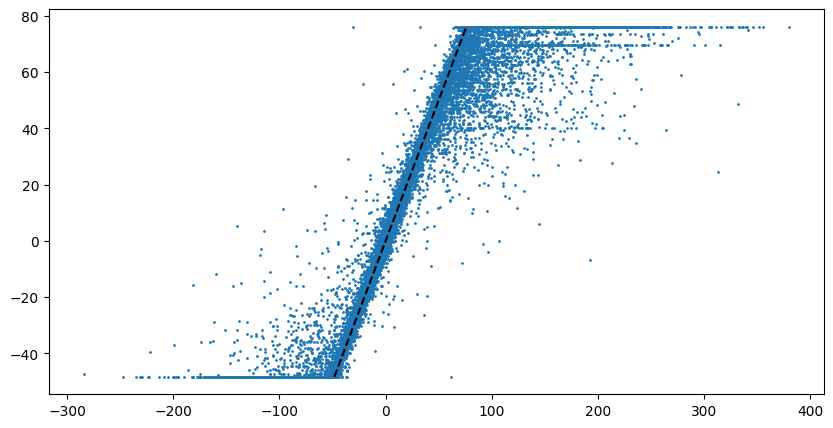

In [161]:
models = []
outputs = []
for test_scale in np.linspace(-3, 3, 20):
    for test_rand in range(1000):
        # input_float = test_scale*np.ones((1,INPUT_SIZE), dtype=np.float32)
        input_float = test_scale*np.random.randn(1,INPUT_SIZE).astype(np.float32)

        output_model = model.act_inference(torch.tensor(input_float))
        models.append(float(output_model.flatten()[0]))

        input_scale = input_details[0]['quantization_parameters']['scales'][0]
        input_zero_point = input_details[0]['quantization_parameters']['zero_points'][0]
        input_quantized = np.clip(np.round(input_float / input_scale + input_zero_point), -128, 127).astype(np.int8)
        interpreter.set_tensor(input_details[0]['index'], input_quantized.reshape((1,INPUT_SIZE)))
        interpreter.invoke()
        output_data = interpreter.get_tensor(output_details[0]['index'])
        output_scale = output_details[0]['quantization_parameters']['scales'][0]
        output_zero_point = output_details[0]['quantization_parameters']['zero_points'][0]
        output_data_float = (output_data.astype(np.float32) - output_zero_point) * output_scale
        outputs.append(output_data_float.flatten()[0])
    
    # print(float(output_model.flatten()[0]), output_data_float.flatten()[0])
plt.figure(figsize=(10, 5))
plt.scatter(models, outputs, s=1)
plt.plot(np.linspace(min(outputs), max(outputs), 100), np.linspace(min(outputs), max(outputs), 100), 'k--')


In [55]:
# test quantized model
num_test_points = 10000
OUTPUT_SIZE = 1

#get quantization parameters from input details
input_scale = input_details[0]['quantization_parameters']['scales'][0]
input_zero_point = input_details[0]['quantization_parameters']['zero_points'][0]

input_float = np.random.uniform(-1, 1, size=(num_test_points,INPUT_SIZE))

# input_quantized = np.round(input_float / input_scale + input_zero_point).astype(np.int8)
input_quantized = np.clip(np.round(input_float / input_scale + input_zero_point), -128, 127).astype(np.int8)

input_quantized = input_quantized.reshape((-1,INPUT_SIZE))

output_data = np.zeros((num_test_points,OUTPUT_SIZE))
for i in range(num_test_points):
    interpreter.set_tensor(input_details[0]['index'], input_quantized[i].reshape((1,INPUT_SIZE)))
    interpreter.invoke()
    output_data[i] = interpreter.get_tensor(output_details[0]['index'])

# Get the quantization parameters from the output details
output_scale = output_details[0]['quantization_parameters']['scales'][0]
output_zero_point = output_details[0]['quantization_parameters']['zero_points'][0]

output_data_float = (output_data.astype(np.float32) - output_zero_point) * output_scale

true_val = func_to_approx(input_float)
pre_quant = keras_model.predict(input_float.reshape((-1,INPUT_SIZE)), verbose=0)

quant_error = pre_quant - output_data_float
true_error = true_val - output_data_float.flatten()
prequant_error =  true_val - pre_quant.flatten()

rms_error = np.sqrt(np.mean(quant_error ** 2)) / np.max(np.abs(true_val))
max_error = np.max(quant_error) / np.max(np.abs(true_val))
min_error = np.min(quant_error) / np.max(np.abs(true_val))
print(f'Quantization error RMS: {rms_error:.2%}')

# get percentage of errors below 2%
below_2_percent = np.sum(np.abs(quant_error) < 0.02) / num_test_points
print(f'Percentage of errors below 2%: {below_2_percent:.2%}')

# get percentage of errors below 5%
below_5_percent = np.sum(np.abs(quant_error) < 0.05) / num_test_points
print(f'Percentage of errors below 5%: {below_5_percent:.2%}')

# percent error where 99% of errors are below this value
percent_error_99 = np.percentile(np.abs(quant_error), 99)
print(f'99% of errors are below: {percent_error_99:.2%}')

# percent error where 97% of errors are below this value
percent_error_97 = np.percentile(np.abs(quant_error), 97)
print(f'97% of errors are below: {percent_error_97:.2%}')

# Create histogram of quantization errors
plt.figure(figsize=(10, 6))
plt.hist(quant_error.flatten(), bins=100, edgecolor='black', alpha=0.6, label='Quantization Error', density=True)
plt.hist(true_error.flatten(), bins=100, edgecolor='black', alpha=0.2, label='True Error', density=True)
plt.hist(prequant_error.flatten(), bins=100, edgecolor='black', alpha=0.2, label='Prequantization Error', density=True)
plt.title('Distribution of Quantization Errors')
plt.xlabel('Error')
plt.ylabel('Count')
plt.legend()
plt.show()

NameError: name 'OUTPUT_SIZE' is not defined

In [193]:
np.max(np.abs(true_val))

5.098274096535212

In [169]:
#check output from ESP32

input_arr = [-0.408691, 0.437988, -0.940918, 0.882324, 0.351562, -0.757324, 0.149414, 0.138672, -0.560547, 0.874023, 0.345215, 0.195801, -0.579590, -0.077637, -0.139648, 0.536133, 0.252441, -0.216797, -0.665527, 0.402832, -0.377930, 0.065918, -0.197266, 0.588867, 0.310547, 0.821777, -0.488281, 0.793457, 0.765625, 0.857422, -0.972168, 0.366211, 0.315918, 0.244141, 0.493652, 0.587891, -0.682129, -0.344238, -0.627930, 0.834961, -0.599121, 0.222168]
input_quantized = np.clip(np.round(input_arr / input_scale + input_zero_point), -128, 127).astype(np.int8)


interpreter.set_tensor(input_details[0]['index'], input_quantized.reshape((1,INPUT_SIZE)))
interpreter.invoke()
output_data_int = interpreter.get_tensor(output_details[0]['index'])

output_data_float = (output_data.astype(np.float32) - output_zero_point) * output_scale
output_data_int, output_data_float

(array([[7]], dtype=int8), array([[0.39591253]], dtype=float32))